In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-03_14-49_20190101_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES        50412.81
GC        33630.90
NQ        65375.72
YM        38154.52
total    187573.95
Name: realizedPNL, dtype: float64

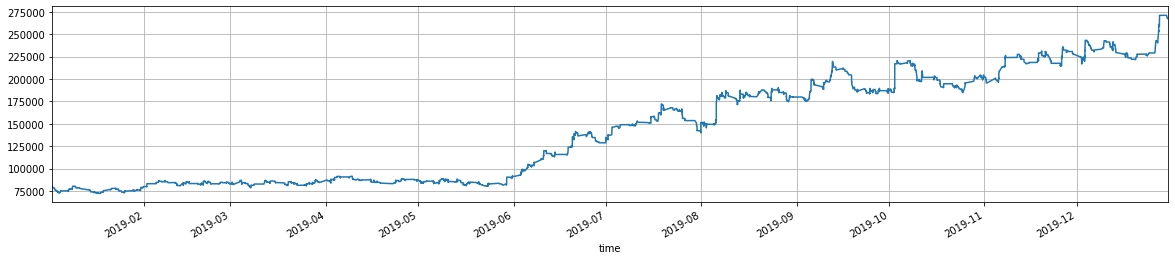

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

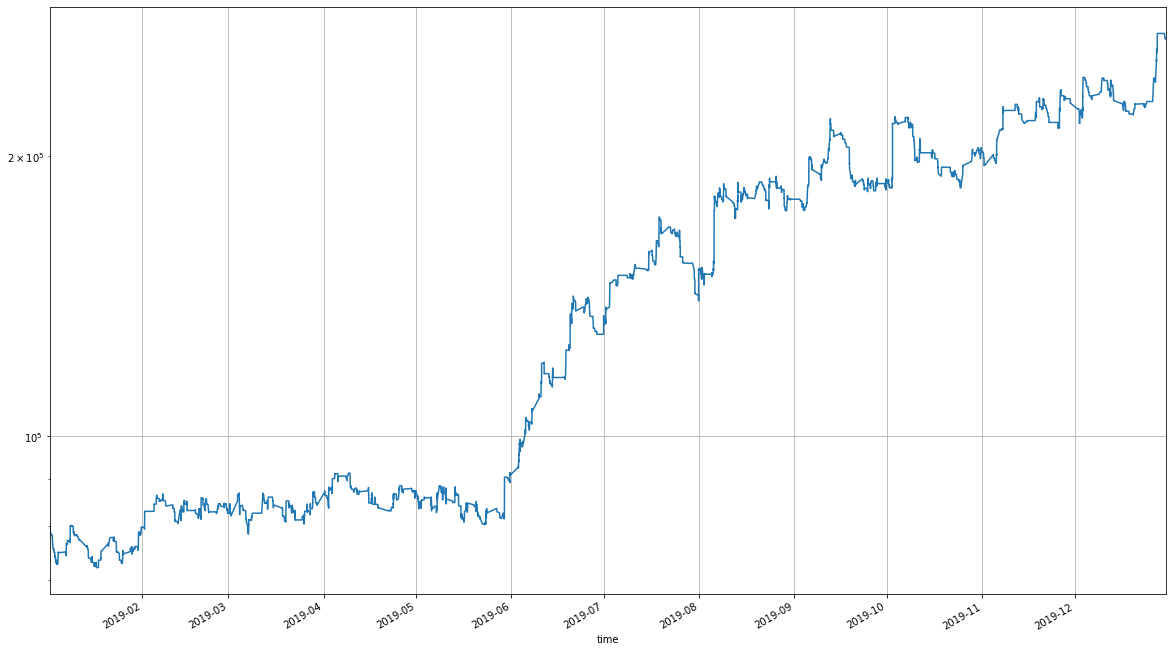

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,NQ,GC,YM,ES
time,,,,
2019-01-31,9.181818,3.000000,3.181818,1.363636
2019-02-28,7.200000,2.650000,2.600000,1.100000
2019-03-31,11.333333,3.857143,3.333333,1.095238
2019-04-30,6.363636,3.363636,2.454545,1.272727
2019-05-31,11.913043,3.391304,3.739130,1.782609
2019-06-30,8.200000,6.000000,2.800000,1.600000
2019-07-31,6.521739,3.739130,2.434783,1.043478
2019-08-31,14.000000,5.636364,4.181818,2.818182
2019-09-30,6.666667,5.428571,2.190476,1.238095


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     368
 GC    1058
 NQ    2164
 YM     712
 Name: action, dtype: int64, 4302)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.420849
 GC    4.084942
 NQ    8.355212
 YM    2.749035
 Name: action, dtype: float64, 16.61003861003861)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        1635.94
GC        6679.10
NQ        9082.28
YM        3073.98
total    20471.30
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        3.2
GC       19.9
NQ       13.9
YM        8.1
total    10.9
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
YM,0.39,68.29,754.55,-371.30,2.03,67.78,1.79,356.0,635.7
NQ,0.39,20.16,430.43,-243.19,1.77,19.52,1.73,1082.0,1876.2
GC,0.39,41.24,552.39,-282.17,1.96,43.31,2.40,529.0,1268.9
ES,0.45,135.68,926.31,-514.05,1.80,134.11,1.85,184.0,341.1
total,0.40,43.19,561.27,-295.29,1.90,47.33,1.92,2151.0,4121.9


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

YM       0.465897
NQ       0.205897
GC       0.395897
ES       0.577778
total    0.400000
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2019-01-02,0.00,-418.00,-2549.12,-4926.56,-1973.42
2019-01-03,-6566.80,-1190.24,-10485.36,903.20,-4334.80
2019-01-04,0.00,1449.76,6846.32,-2594.56,1425.38
2019-01-07,0.00,-750.24,385.84,9065.44,2175.26
2019-01-08,11783.20,-2442.00,777.92,1497.44,2904.14
...,...,...,...,...,...
2019-12-24,0.00,13582.56,0.00,0.00,3395.64
2019-12-25,0.00,0.00,0.00,0.00,0.00
2019-12-26,0.00,54518.56,0.00,0.00,13629.64


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2019-01-02,0.000000,-0.001306,-0.007966,-0.015396,-0.024668
2019-01-03,-0.021040,-0.003814,-0.033595,0.002894,-0.055555
2019-01-04,0.000000,0.004918,0.023226,-0.008802,0.019342
2019-01-07,0.000000,-0.002497,0.001284,0.030171,0.028958
2019-01-08,0.038112,-0.007899,0.002516,0.004843,0.037573
...,...,...,...,...,...
2019-12-24,0.000000,0.015051,0.000000,0.000000,0.015051
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.059516,0.000000,0.000000,0.059516


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

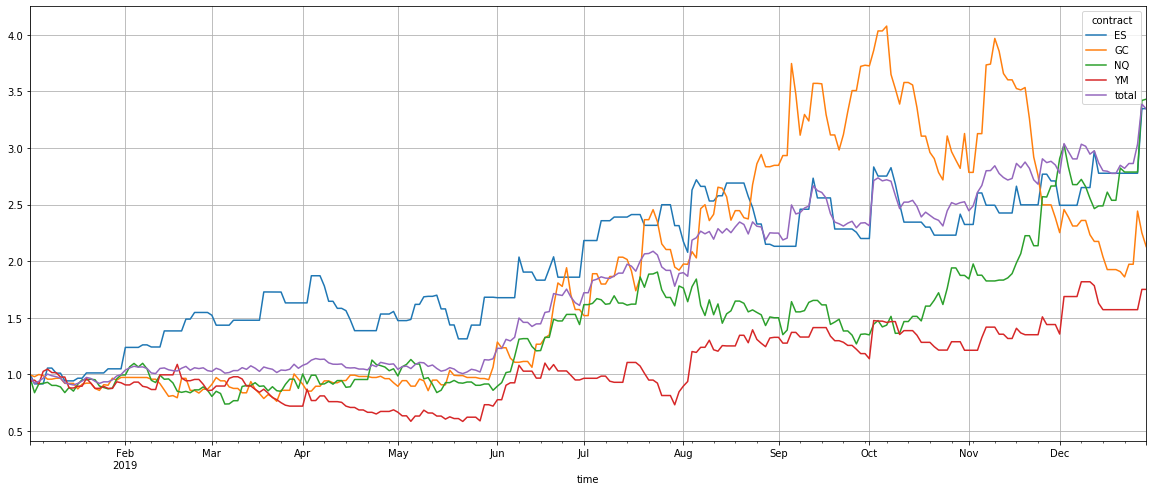

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.107551,0.205823,0.378128,0.583916
GC,-0.107551,1.000000,0.014548,0.055610,0.478809
NQ,0.205823,0.014548,1.000000,0.203935,0.592554
YM,0.378128,0.055610,0.203935,1.000000,0.681378
total,0.583916,0.478809,0.592554,0.681378,1.000000


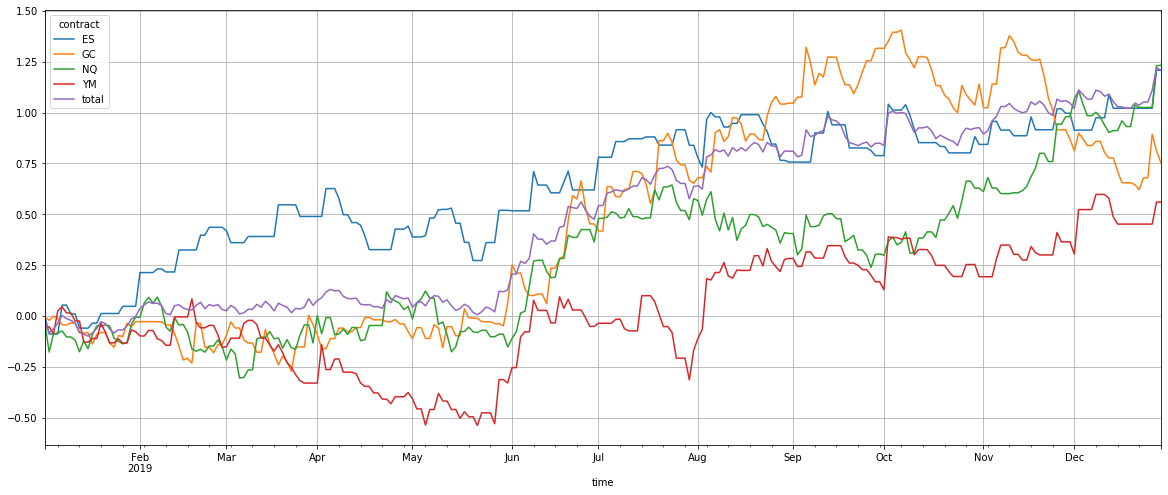

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

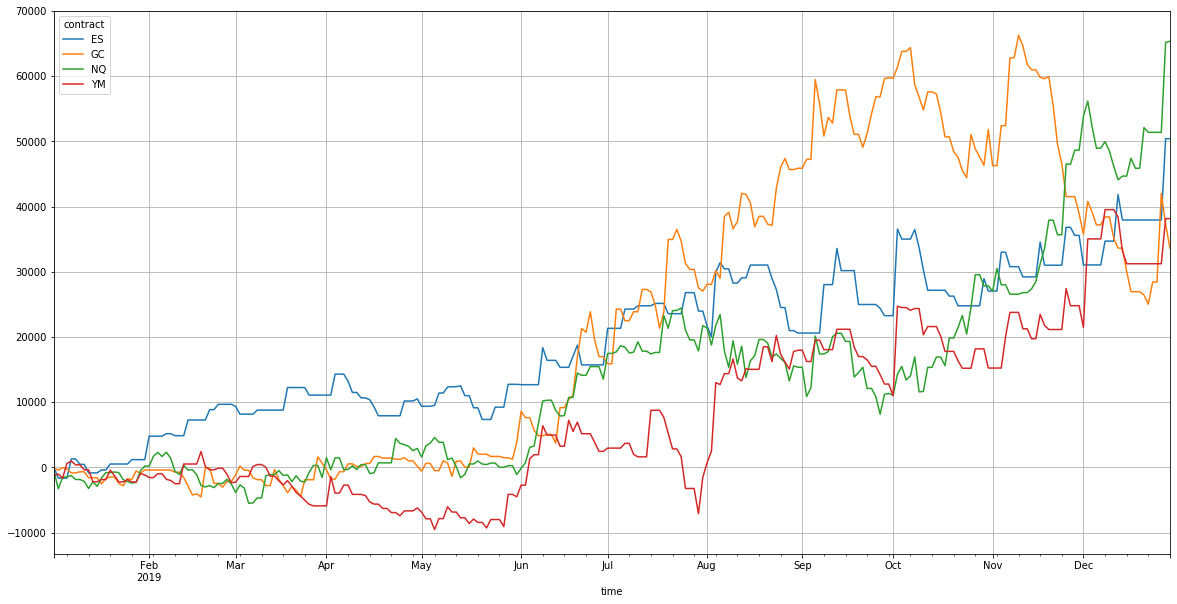

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,2.239605,1.085696,2.318159,0.724290,2.237294
Cumulative returns,2.347128,1.128723,2.430572,0.750583,2.344674
Annual volatility,0.840400,1.043934,0.889395,0.913346,0.540061
Sharpe ratio,1.791229,1.192484,1.783116,1.020185,2.438565
Calmar ratio,7.519011,1.997368,6.951228,1.563804,14.425489
Stability,0.830691,0.762409,0.809355,0.564460,0.919662
Max drawdown,-0.297859,-0.543563,-0.333489,-0.463159,-0.155093
Omega ratio,1.634558,1.271713,1.391064,1.258860,1.584757
Sortino ratio,3.939215,2.365945,3.072252,2.104259,5.227458
Skew,2.174290,1.598196,0.705984,2.091754,1.720362


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.425520,0.320152,0.450293,0.230488,2.237294
Cumulative returns,0.439628,0.330377,0.465347,0.237598,2.344674
Annual volatility,0.210100,0.260983,0.222349,0.228337,0.540061
Sharpe ratio,1.791229,1.192484,1.783116,1.020185,2.438565
Calmar ratio,5.368151,1.910298,4.996035,1.717614,14.425489
Stability,0.887361,0.823163,0.870948,0.707278,0.919662
Max drawdown,-0.079267,-0.167593,-0.090130,-0.134191,-0.155093
Omega ratio,1.634558,1.271713,1.391064,1.258860,1.584757
Sortino ratio,3.939215,2.365945,3.072252,2.104259,5.227458
Skew,2.174290,1.598196,0.705984,2.091754,1.720362


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2019-01-31,1.57,-0.48,0.41,-1.47,-0.17
2019-02-28,10.69,-2.19,-3.24,-1.44,3.47
2019-03-31,1.65,3.30,1.14,-4.08,2.02
2019-04-30,-0.74,-0.71,5.42,-0.55,3.68
2019-05-31,2.61,4.17,-4.40,1.99,4.10
2019-06-30,3.10,11.92,14.56,8.11,41.46
2019-07-31,6.09,6.69,6.12,-2.04,17.49
2019-08-31,-1.27,11.25,-3.47,13.01,18.90
2019-09-30,1.27,8.18,-1.81,-2.66,4.08


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(11.099166666666667, 6.005000000000001)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2019-06-30    41.46
2019-08-31    18.90
2019-07-31    17.49
2019-12-31    17.39
2019-11-30    12.86
2019-10-31     7.91
2019-05-31     4.10
2019-09-30     4.08
2019-04-30     3.68
2019-02-28     3.47
2019-03-31     2.02
2019-01-31    -0.17
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        44.0
GC        33.0
NQ        47.0
YM        24.0
total    234.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 21:00:00,ES,BUY,2893.75,13283.20
2019-12-27 15:12:00,NQ,SELL,8829.25,12850.60
2019-12-26 17:19:00,GC,SELL,1513.70,12681.28
2019-10-02 20:45:30,YM,BUY,26063.00,12203.20
2019-12-27 21:50:30,ES,SELL,3235.50,11541.50
...,...,...,...,...
2019-12-30 10:48:30,GC,SELL,1515.30,-3648.40
2019-12-12 14:03:00,YM,SELL,27873.00,-3739.40
2019-12-13 16:30:30,YM,SELL,28180.00,-3775.20


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,13283.20,1693.94,3221.48,13726.00,31924.62
2019-12-27,12462.74,-4778.44,13765.90,6916.92,28367.12
2019-08-05,9879.39,2111.20,3019.96,10528.08,25538.63
2019-09-05,0.00,12218.24,7941.76,3274.96,23434.96
2019-12-03,0.00,5040.48,2312.44,13563.94,20916.86
...,...,...,...,...,...
2019-08-28,-3539.79,-1689.06,-2859.44,-1086.48,-9174.77
2019-10-10,-3441.68,-1988.00,80.96,-4021.92,-9370.64
2019-10-09,-2748.68,-1874.20,-5372.48,0.00,-9995.36


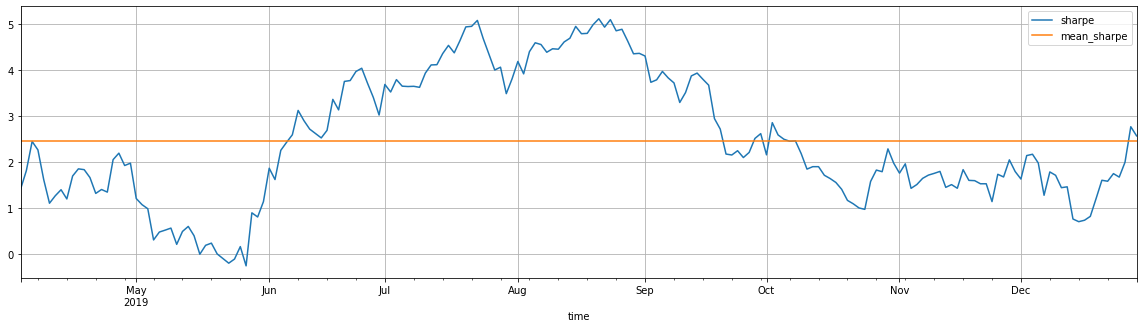

In [30]:
plot_rolling_sharpe(returns.total, 3)

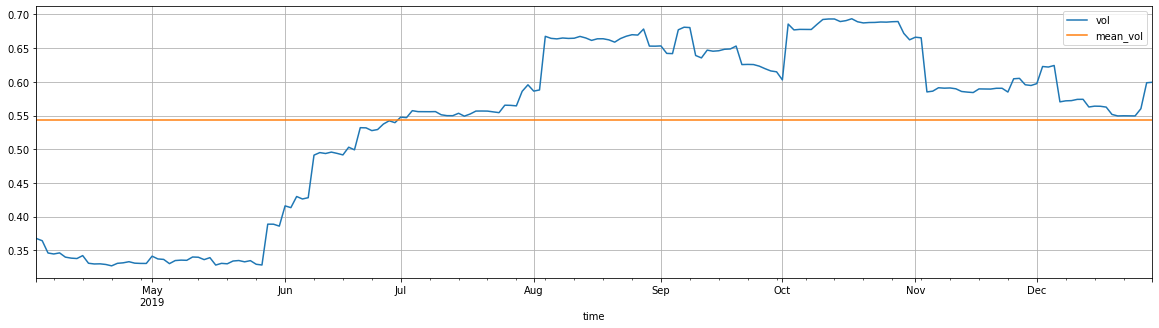

In [31]:
plot_rolling_vol(returns.total, 3)